# Проект "Создание симмуляционной модели"

Работу выполняли:
1) Володченко Полина
2) Мелехина Алина
3) Хатунцев Сергей
4) Цуканов Александр

In [2]:
# Все необходимы импорты
import math
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.optimize import minimize
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import kstest, binomtest
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import LinearRegression

from typing import Tuple, List, Callable, Dict

warnings.filterwarnings('ignore')

### Модель CIR  

- USD interest rate:  
$dr^{USD}_t = \alpha^{USD} (\theta^{USD} - r^{USD}_t)dt + \sigma^{USD} \sqrt{r^{USD}_t} dW^{USD}_t$
- RUB interest rate:  
$dr^{RUB}_t = \alpha^{RUB} (\theta^{RUB} - r^{RUB}_t)dt + \sigma^{RUB} \sqrt{r^{RUB}_t} dW^{RUB}_t + J_t dN_t$
- Exchange rate:  
$\frac{dS_t}{S_t} = (r^{USD}_t - r^{RUB}_t)dt + \eta dZ_t$  

### Генерация коррелированных случайных величин

Задаем корреляционную матрицу:   
$\mathbf{\Sigma} = \begin{bmatrix}
1 & \rho_{r^{USD}, r^{RUB}} & \rho_{r^{USD}, S} \\
\rho_{r^{USD}, r^{RUB}} & 1 & \rho_{r^{RUB}, S} \\
\rho_{r^{USD}, S} & \rho_{r^{RUB}, S} & 1
\end{bmatrix}$  
  
Выполняем разложение Холецкого:  
$\mathbf{\Sigma} = \mathbf{L} \mathbf{L^T}$
   
Генерируем вектор случайных нормальных величин с помощью преобразования Бокса - Мюллера:  
$\xi = \begin{bmatrix} \ \xi_1 \\ \xi_2 \\ \xi_3 \end{bmatrix}$, где $\xi_i \sim N(0, \Delta t)$

Получаем вектор скоррелированных случайных величин:
$\epsilon = \mathbf{L} z = \begin{bmatrix} \ \epsilon_1 \\ \epsilon_2 \\ \epsilon_3 \end{bmatrix}$,   
где   
- $\epsilon_1$ - для $dW^{USD}_t$
- $\epsilon_2$ - для $dW^{RUB}_t$
- $\epsilon_3$ - для $dZ_t$
  
### Схема Эйлера - Мурояна

- USD interest rate  
$r^{USD}_{t+\Delta t} = r^{USD}_t + \alpha^{USD} (\theta^{USD} - r^{USD}_t) \Delta t + \sigma^{USD} \sqrt{r^{USD}_t} \sqrt{\Delta t_{\epsilon_1}}$
- RUB interest rate:   
$r^{RUB}_{t+\Delta t} = r^{RUB}_t + \alpha^{RUB} (\theta^{RUB} - r^{RUB}_t) \Delta t + \sigma^{RUB} \sqrt{r^{RUB}_t} \sqrt{\Delta t_{\epsilon_1}} + J_t \Delta N_t$
- Exchange rate:   
$S_{t+\Delta t} = S_t exp((r^{USD}_t - r^{RUB}_t - \frac{1}{2} \eta^2) \Delta t + \eta \sqrt{\Delta t_{\epsilon_3}})$

## Определение всех функций необходимых для симуляции

In [3]:
# Генерация нормального распределения при помощи преобразования Бокса-Мюллера
def gaussian(
    u1: np.array,
    u2: np.array
) -> Tuple[np.array, np.array]:
    z1 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    z2 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
    return z1,z2

In [4]:
# Расчет корреляций рельных данных
def correlations(
    data: np.array
) -> np.array:

    return np.corrcoef(data, rowvar=False)

In [5]:
# Функция для генерации реализации виннеровского процесса
def d_wiener_process(
    N: int,
    T: int
) -> np.array:
    delta_t_sqrt = math.sqrt(T / N)
    u1 = np.random.rand(N)
    u2 = np.random.rand(N)
    z, _ = gaussian(u1,u2)
    w = delta_t_sqrt * z
    return w

In [6]:
# Функция для создания скоррелированных виннеровских процессов
def generate_wieners_for_simulations(
    N: int,
    T: int,
    corrs: np.array
) -> np.array:

    # приращения виннеровских процессов для ставок и обменного курса
    w_foreighn = d_wiener_process(N, T)
    w_domestic = d_wiener_process(N, T)
    w_fx = d_wiener_process(N, T)

    processes =  np.array((w_foreighn, w_domestic, w_fx))

    # Матрица L получаемая после разложения Холецкого
    l_matrix = np.linalg.cholesky(corrs)

    # Сгенерили скоррелированные приращения для построения симуляция
    eps = (l_matrix @ processes)

    return eps

In [7]:
# Функция, которая строит CIR симуляцию при заданных параметрах
def simulate_cir(
    wiener: np.array,
    k: float,
    theta: float,
    sigma: float,
    r0: float,
    T: int,
    N: int
) -> np.array:

    dt = T / N
    paths = np.zeros(N + 1)
    paths[0] = r0

    for t in range(1, N + 1):
        w = wiener[t - 1] # сразу предполагаем что w пришло из N(0, Sqrt(dt))
        r_prev = paths[t - 1]
        r_new = r_prev + k * (theta - r_prev) * dt + sigma * np.sqrt(r_prev) * w
        paths[t] = max(r_new, 0)

    return paths

### Оценка параметров модели CIR при помощи линейной регрессии

Модель CIR в общем виде:

$dr_t = \alpha(\theta- r_t)dt + \sigma \sqrt{r_t} dW_t$ , где

$\alpha$ - интенсивность, с которой процесс возвращается к своему долгосрочному среднему

$\theta$ - долгосрочный средний показатель

$\sigma$ - мгновенная волатильность

### Дискретизация модели и получения оценок обычных наименьших квадратов (OLS)  

Дискретизация модели достигается с помощью схемы Эйлера-Маруямы:

$r_{t+\Delta t} - r_t = \alpha (\theta - r_t) \Delta t + \sigma \sqrt{r_t}N(0,\Delta t)$

После некоторых простых манипуляций его можно переписать как:

$\frac{r_{t+\Delta t} - r_t}{\sqrt{r_t}} = \frac{\alpha\theta\Delta t}{\sqrt{r_t}} - \alpha\sqrt{r_t}\Delta t + \sigma \sqrt{\Delta t}N(0,1)$

Это можно интерпретировать как:

$y_i = \beta_1z_1,i + \beta_2z_2,i + \epsilon_i$, где

$y_i$ = $\frac{r_{t+\Delta t} - r_t}{\sqrt{r_t}}$

$\beta_1$ = $\alpha\theta$

$z_1,i$ = $\frac{\Delta t}{\sqrt{r_t}}$

$\beta_2$ = $-\alpha$

$z_2,i$ = $\sqrt{r_t}\Delta t$

$\epsilon_i$ = $\sigma \sqrt{\Delta t}N(0,1)$

Наконец, оценка интересующих параметров:

$\alpha'$ = $-\beta_2'$

$\theta'$ = $\frac{\beta_1'}{\alpha'}$

$\sigma'^2$ = $\frac{Var'(\epsilon)}{\Delta t}$

In [8]:
# Функция для оценки парамктров CIR модели при помощи линейной регрессии
def compute_cir_params(
    data: np.array,
    dt: float
) -> Tuple[float, float, float]:

    n_steps = len(data)
    current = data[:n_steps-1]
    future = data[1:n_steps]

    changes = (future - current) / np.sqrt(current)
    term1 = dt / np.sqrt(current)
    term2 = dt * np.sqrt(current)
    predictors = np.column_stack((term1, term2))

    model = sm.OLS(changes, predictors)
    results = model.fit()
    coeffs = results.params
    resids = results.resid

    coef1 = coeffs[0]
    coef2 = coeffs[1]

    # Параметрвы CIR согласно статье представденной выше
    k = -coef2
    theta = coef1 / k
    sigma = np.std(resids) / np.sqrt(dt)

    return k, theta, sigma

### Оценка параметров модели CIR при помощи ММП
Метод максимального правдоподобия является статистическим методом, используемым для оценки параметров статистических моделей. Основная идея заключается в нахождении таких значений параметров, которые максимизируют правдоподобие наблюдаемых данных.

**Основные шаги метода:**

Предположим, что заданная выборка данных подчиняется какому-либо известному распределению. Задача заключается в оценке параметров этого распределения.
В случае модели CIR изменения $dr_t = r_{t+\Delta t} - r_t $ моделируются через условное нормальное распределение, учитывающее дисперсию, пропорциональную текущему значению процесса $r_t$ :
$ dr_t$ ~ $N(k(\theta-r_t)\Delta t,\sigma^2r_t\Delta t) $

Рассматривается функция правдоподобия, которая измеряет, насколько вероятно получить наблюдаемые данные при данном наборе параметров модели. Для нормального распределения функция правдоподобия будет основываться на плотности нормального распределения. Так как проще работать с суммой, а не произведением, рассматриваем логарифмическое правдоподобие:
$logL(μ,σ|x_1,...,x_n)=-\frac{n}{2}log(2π)-nlog(σ)-\frac{1}{2\sigma^2}Σ_{i=1}^{n}(x_i-μ)^2$

Далее ищем μ,σ, при которых логарифмическое правдоподобие максимизируется методом дифференцирования функции по каждому параметру и поиска точек, в которых производные обращаются в ноль.

Оцениваем логарифм функции правдоподобия для нормального распределения прироста с усреднением средней разницы и дисперсии:

среднее: $k(\theta-r_t)\Delta t$

дисперсия: $\sigma^2r_t$ - это соответствует нормальному приближению прироста процесса.

In [9]:
# Правдоподобие для модели CIR
def log_likelihood_cir(
    params: List[float],
    data: np.array,
    dt: float
) -> float:

    k, theta, sigma = params
    N = len(data)

    log_likelihood = 0
    for t in range(1, N):
        r_prev = data[t - 1]
        r_curr = data[t]
        dr = r_curr - r_prev

        mu_diff = k * (theta - r_prev) * dt
        var_diff = sigma ** 2 * r_prev

        if var_diff <= 0:
            var_diff = 1e-10

        log_pdf = -0.5 * (np.log(2 * np.pi * var_diff) + ((dr - mu_diff) ** 2) / var_diff)
        log_likelihood += log_pdf

    return -log_likelihood

In [10]:
# Функция для оценки парамктров CIR модели при помощи ММП
def cir_params(
    data: np.array,
    initial_params: List[float],
    dt: float,
    bounds: List[Tuple[float, float]],
    likelyhood: Callable
) -> Tuple[float]:

    result = minimize(
    likelyhood,
    initial_params,
    args=(data, dt),
    bounds=bounds,
    method='L-BFGS-B',
)
    k, theta, sigma = result.x

    return k, theta, sigma

In [11]:
# Генерация пуассоновского процесса с помощью inverse transform
def poisson_sample(
    lambda_j_dt: float
) -> int:
    L = np.exp(-lambda_j_dt)  # e^(-λ)
    k = 0
    p = 1

    while p > L:
        k += 1
        p *= np.random.uniform()

    return k - 1

In [12]:
# Функция, которая строит CIR симуляцию с пуассоновскими джампами при заданных параметрах
def simulate_cir_with_jumps(
    wiener: np.array,
    k: float,
    theta: float,
    sigma: float,
    r0: float,
    T: int,
    N: int,
    lambda_j: float,
    jump_mean: float,
    jump_std: float
) -> np.array:

    dt = T / N
    paths = np.zeros(N + 1)
    paths[0] = r0

    for t in range(1, N + 1):
        w = wiener[t - 1] # сразу предполагаем что w пришло из N(0, Sqrt(dt))
        r_prev = paths[t - 1]

        jump_occurs = poisson_sample(lambda_j * dt)
        if jump_occurs > 0:
            u1 = np.random.rand(1)
            u2 = np.random.rand(1)
            z, _ = gaussian(u1,u2)
            jump_size = (z + jump_mean) * jump_std
        else:
            jump_size = 0

        r_new = r_prev + k * (theta - r_prev) * dt + sigma * np.sqrt(r_prev) * w + jump_size
        paths[t] = max(r_new, 0)

    return paths

In [13]:
# Правдоподобие для модели CIR с пуассновскими джампами
def log_likelihood_cir_jumps(
    params: List[float],
    data: np.array,
    dt: float
) -> float:
    k, theta, sigma, lambda_j, jump_mean, jump_std = params
    N = len(data)

    log_likelihood = 0
    for t in range(1, N):
        r_prev = data[t - 1]
        r_curr = data[t]
        dr = r_curr - r_prev

        p0 = np.exp(-lambda_j * dt)
        pj = 1 - p0

        mu_diff = k * (theta - r_prev) * dt
        var_diff = sigma ** 2 * r_prev
        pdf_diff = p0 * norm.pdf(dr, loc=mu_diff, scale=np.sqrt(var_diff))


        mu_jump = mu_diff + jump_mean
        var_jump = var_diff + jump_std ** 2
        pdf_jump = pj * norm.pdf(dr, loc=mu_jump, scale=np.sqrt(var_jump))


        total_pdf = pdf_diff + pdf_jump
        if total_pdf <= 0:
            total_pdf = 1e-10

        log_likelihood += np.log(total_pdf)

    return -log_likelihood

In [14]:
# Функция для оценки параметров CIR модели с пуассновскими джампами при помощи ММП
def cir_with_jumps_params(
    data: np.array,
    initial_params: List[float],
    dt: float,
    bounds: List[Tuple[float, float]],
    likelyhood: Callable
) -> Tuple[float]:

    result = minimize(
    likelyhood,
    initial_params,
    args=(data, dt),
    bounds=bounds,
    method='L-BFGS-B',
)
    k, theta, sigma, lambda_j, jump_mean, jump_std = result.x

    return k, theta, sigma, lambda_j, jump_mean, jump_std

In [15]:
# Функция, которая построения симмуляции обменного курса
def simulate_exchange_rate(
    wiener: np.array,
    r_ru: np.array,
    r_us: np.array,
    sigma: float,
    s0: float,
    T: int,
    N: int
) -> np.array:

    dt = T / N
    paths = np.zeros(N + 1)
    paths[0] = s0

    for t in range(1, N+1):
        w = wiener[t - 1] # сразу предполагаем что w пришло из N(0, Sqrt(dt))
        s_prev = paths[t - 1]
        r_ru_prev = r_ru[t - 1]
        r_us_prev = r_us[t - 1]

        s_new = s_prev * np.exp((r_us_prev - r_ru_prev - 0.5 * sigma ** 2) * dt + sigma * w)

        paths[t] = s_new

    return paths

In [16]:
# Функция, которая запускает весь пайплайн построения симмуляций
def simulate(
    num_sims: int,
    N: int,
    T: int,
    data: np.array,
    k_ru: float,
    theta_ru: float,
    sigma_ru: float,
    lambda_j_ru: float,
    jump_mean_ru: float,
    jump_std_ru: float,
    k_us: float,
    theta_us: float,
    sigma_us: float,
    sigma_er: float
) -> Tuple[np.array]:

    r_ru_simulations = np.zeros((num_sims, N + 1))
    r_us_simulations = np.zeros((num_sims, N + 1))
    exch_rate_simulations = np.zeros((num_sims, N + 1))

    for sim_index in range(num_sims):
        wieners = generate_wieners_for_simulations(
            N=N,
            T=T,
            corrs=correlations(data[['rate_rub', 'rate_usd', 'exchange_rate']].values)
        )

        r_ru = simulate_cir_with_jumps(
            wiener=wieners[0, :],
            k=k_ru,
            theta=theta_ru,
            sigma=sigma_ru,
            r0=data['rate_rub'].iloc[-1],
            T=T,
            N=N,
            lambda_j=lambda_j_ru,
            jump_mean=jump_mean_ru,
            jump_std=jump_std_ru
        )

        r_us = simulate_cir(
            wiener=wieners[1, :],
            k=k_us,
            theta=theta_us,
            sigma=sigma_us,
            r0=data['rate_usd'].iloc[-1],
            T=T,
            N=N
        )

        exch_rate = simulate_exchange_rate(
            wiener=wieners[2, :],
            r_ru=r_ru,
            r_us=r_us,
            sigma=sigma_er,
            s0=data['exchange_rate'].iloc[-1],
            T=T,
            N=N
        )

        r_ru_simulations[sim_index, :] = r_ru
        r_us_simulations[sim_index, :] = r_us
        exch_rate_simulations[sim_index, :] = exch_rate

    fig, axes = plt.subplots(3, 1, figsize=(12, 18))
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, num_sims))

    for i in range(num_sims):
        axes[0].plot(r_ru_simulations[i, :], color=colors[i], alpha=0.05)
    axes[0].set_title('Ru interest rate')
    axes[0].set_xlabel('time')
    axes[0].set_ylabel('rate')

    for i in range(num_sims):
        axes[1].plot(r_us_simulations[i, :], color=colors[i], alpha=0.05)
    axes[1].set_title('Us interest rate')
    axes[1].set_xlabel('time')
    axes[1].set_ylabel('rate')

    for i in range(num_sims):
        axes[2].plot(exch_rate_simulations[i, :], color=colors[i], alpha=0.05)
    axes[2].set_title('Exchange rate')
    axes[2].set_xlabel('time')
    axes[2].set_ylabel('rate')

    plt.tight_layout()
    plt.show()

    return r_ru_simulations, r_us_simulations, exch_rate_simulations

In [17]:
# Функция, оценки перформанса на основе точечной оценки
def model_performance_one(
    simulated_data_dict: Dict[str, np.array],
    observed_data_dict: Dict[str, np.array],
    significance_level: float=0.05

) -> Dict[str, float]:

    results_dict = {}

    for variable_name in simulated_data_dict.keys():
        simulated_data = simulated_data_dict[variable_name]  #(num_sims, N)
        observed_data = observed_data_dict[variable_name]    #(N, 0)

        N = observed_data.shape[0]
        U_values = []

        for t in range(N):
            sim_values_t = simulated_data[:, t]
            obs_value_t = observed_data[t]

            ecdf = ECDF(sim_values_t)
            U_i = ecdf(obs_value_t)
            U_values.append(U_i)

        U_values = np.array(U_values)

        ks_statistic, p_value = kstest(U_values, 'uniform')
        results_dict[variable_name] = {'KS Statistic': ks_statistic, 'P-value': p_value}

        print(f'\n{variable_name}:')
        print(f'KS статистика: {ks_statistic:.4f}, P-value: {p_value:.4f}')
        if p_value > significance_level:
            print('Не удалось отклонить нулевую гипотезу о том, что реализации попрождают равномерное распределение')
            print('Модель хорошо подходит под реальные данные')
        else:
            print('Нулевую гипотеза о том, что реализации попрождают равномерное распределение отвергается')
            print('Модель плохо подходит под реальные данные')

        plt.figure(figsize=(10, 6))
        # plt.style.use('seaborn-whitegrid')
        plt.style.use('seaborn-v0_8-whitegrid')

        plt.hist(
            U_values,
            bins=50,
            density=True,
            alpha=0.8,
            color='cornflowerblue',
            edgecolor='white',
            linewidth=1
        )

        plt.title(f'{variable_name}', fontsize=16)
        plt.xlabel('значения u', fontsize=14)
        plt.ylabel('плотность', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

    return results_dict

In [18]:
# Функция, оценки перформанса на основе интервальной оценки
def model_performance_two(
    simulated_data_dict: Dict[str, np.array],
    observed_data_dict: Dict[str, np.array],
    confidence_level: float=0.8,
    significance_level: float=0.05
) -> Dict[str, float]:

    results_dict = {}

    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100

    for variable_name in simulated_data_dict.keys():
        simulated_data = simulated_data_dict[variable_name]  #(num_sims, N)
        observed_data = observed_data_dict[variable_name]    #(N, 0)

        N = observed_data.shape[0]

        inside_interval = []
        lower_bounds = []
        upper_bounds = []

        for t in range(N):
            sim_values_t = simulated_data[:, t]
            obs_value_t = observed_data[t]

            lower_bound = np.percentile(sim_values_t, lower_percentile)
            upper_bound = np.percentile(sim_values_t, upper_percentile)
            lower_bounds.append(lower_bound)
            upper_bounds.append(upper_bound)
            inside_interval.append(int(lower_bound <= obs_value_t <= upper_bound))

        n_trials = N
        k_successes = sum(inside_interval)
        p_null = confidence_level

        p_value_binom = binomtest(k_successes, n_trials, p=p_null) # binom_test(k_successes, n_trials, p_null)
        results_dict[variable_name] = {'Успехи': k_successes, 'P-value': p_value_binom}

        print(f'\n{variable_name}:')
        print(f'Число успехов: {k_successes} из {n_trials} попыток')
        # print(f'P-value from binomial test: {p_value_binom:.4f}')
        print(f'P-value from binomial test: {p_value_binom.pvalue:.4f}')
        # if p_value_binom > significance_level:
        if p_value_binom.pvalue > significance_level:
            print('Не удалось отклонить нулевую гипотезу, наблюдаемая пропорция соответствует доверительному интервалу')
            print('Модель хорошо подходит под реальные данные')
        else:
            print('Отвергаем нулевую гипотезу:')
            print('Модель плохо подходит под реальные данные')

        lower_bounds = np.array(lower_bounds)
        upper_bounds = np.array(upper_bounds)


        plt.figure(figsize=(12, 7))
        plt.plot(
            range(N),
            observed_data,
            label='наблюдаемое значение',
            color='black',
            marker='o',
            markersize=6,
            linewidth=2,
            linestyle='-'
        )
        plt.fill_between(
            range(N),
            lower_bounds,
            upper_bounds,
            color='cornflowerblue',
            alpha=0.3,
            label=f'{int(confidence_level*100)}% доверительный интервал'
        )

        plt.title(f'{variable_name}', fontsize=16)
        plt.xlabel('time', fontsize=14)
        plt.ylabel(variable_name, fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()

    return results_dict

## Симмуляция

Данные по процентной ставке и курсу рубля взяты с сайта [ЦБ](https://www.cbr.ru/hd_base/mkr/mkr_base/?UniDbQuery.Posted=True&UniDbQuery.From=01.11.2024&UniDbQuery.To=29.11.2024&UniDbQuery.st=SF&UniDbQuery.st=HR&UniDbQuery.st=MB&UniDbQuery.ob=OB_MIACR_0&UniDbQuery.ob=OB_MIACR_IG&UniDbQuery.ob=OB_MIACR_B&UniDbQuery.Currency=-1&UniDbQuery.sk=Dd1_&UniDbQuery.sk=Dd7&UniDbQuery.sk=Dd30&UniDbQuery.sk=Dd90&UniDbQuery.sk=Dd180&UniDbQuery.sk=Dd360), данные по ставке доллара с [сайта](https://www.federalreserve.gov/) правительства США.

In [19]:
data = pd.read_excel('full_data.xlsx', index_col=0)
data['dttm'] = pd.to_datetime(data['dttm'])
data.drop('miacr usd', axis=1, inplace=True)
data.columns = ['dttm', 'rate_rub', 'exchange_rate', 'rate_usd']

In [20]:
# Константы - их можно изменять
T = 1 # временной период
N = 252 # период прогноза - 1 год
num_sims = 1000 # число симмуляций
dt = T / N

# пока очень тупой способ обработки пропусков
# df_reduced = data[(data['dttm'] <= '2021-12-10') & (data['dttm'] >= '2018-12-10')].dropna()
# observed = data[data['dttm'] >= '2021-12-10'].dropna().iloc[:252,:]

df_filled = data.sort_values(by='dttm')
for col in df_filled.drop('dttm', axis=1).columns:
    df_filled[col] = df_filled[col].bfill()
# df_filled.isna().sum()

df_reduced = df_filled[(data['dttm'] <= '2021-12-10') & (data['dttm'] >= '2018-12-10')]
observed = df_filled[data['dttm'] >= '2021-12-10'].dropna().iloc[:252,:]

In [21]:
# Посмотрим на исторические данные
df_reduced.tail(5)

,dttm,rate_rub,exchange_rate,rate_usd
5590,2021-12-06,7.23,73.6694,0.08
5591,2021-12-07,7.29,74.1399,0.08
5592,2021-12-08,7.48,73.8453,0.08
5593,2021-12-09,7.48,73.5998,0.08
5594,2021-12-10,7.47,73.6059,0.08


In [22]:
# Посмотрим на данные, необходимые для прогнозирования
observed.head(5)

,dttm,rate_rub,exchange_rate,rate_usd
5594,2021-12-10,7.47,73.6059,0.08
5595,2021-12-13,7.40,73.4107,0.08
5596,2021-12-14,7.37,73.4698,0.08
5597,2021-12-15,7.36,73.8510,0.08
5598,2021-12-16,7.38,73.5708,0.08


In [23]:
# Подбор параметров RU ставки
initial_params = [0.5, 0.1, 0.05, 1, 0.05, 1] # [k, theta, sigma, lambda_j, jump_mean, jump_std]
bounds = [(1e-6, None), (1e-6, None), (1e-6, None), (1e-6, None), (None, None), (1e-6, None)]
k_ru, theta_ru, sigma_ru, lambda_j_ru, jump_mean_ru, jump_std_ru = cir_with_jumps_params(df_reduced['rate_rub'].values,
                                                                       initial_params,
                                                                       dt,
                                                                       bounds,
                                                                       log_likelihood_cir_jumps)

In [24]:
# Подбор параметров US ставки
initial_params = [0.5, 0.02, 0.01]  # [k, theta, sigma]
bounds = [(1e-6, None), (1e-6, None), (1e-6, None)]
k_us, theta_us, sigma_us = cir_params(df_reduced['rate_usd'].values,
                             initial_params,
                             dt,
                             bounds,
                             log_likelihood_cir)
# k_us, theta_us, sigma_us = compute_cir_params(data=df_reduced['rate_usd'].values, dt=dt)

In [25]:
# Подбор параметров Exchange Rate
sigma_er = np.std(np.diff(np.log(df_reduced['exchange_rate'])))

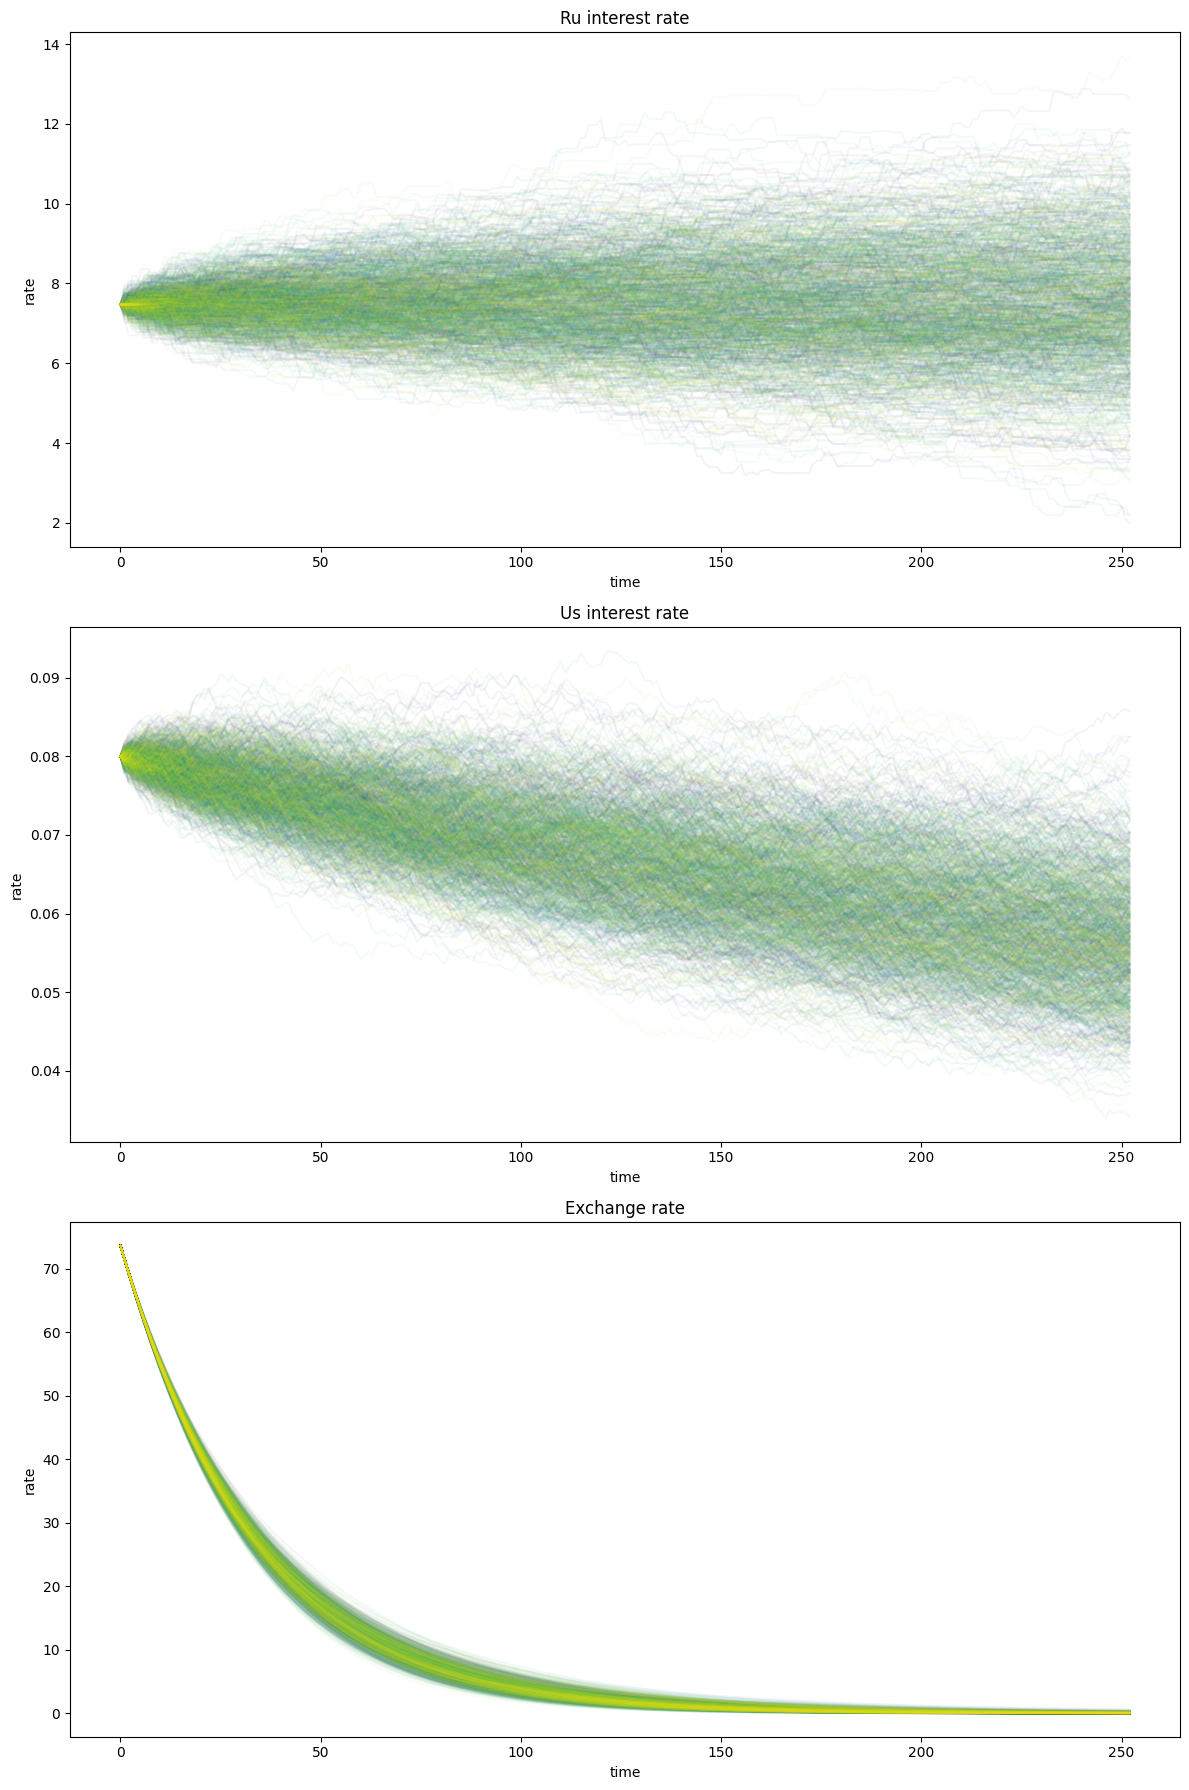

In [26]:
# Запуск полной симмуляции
r_ru_simulations, r_us_simulations, exch_rate_simulations = simulate(
    num_sims=num_sims,
    N=N,
    T=T,
    data=df_reduced,
    k_ru=k_ru,
    theta_ru=theta_ru,
    sigma_ru=sigma_ru,
    lambda_j_ru=lambda_j_ru,
    jump_mean_ru=jump_mean_ru,
    jump_std_ru=jump_std_ru,
    k_us=k_us,
    theta_us=theta_us,
    sigma_us=sigma_us,
    sigma_er=sigma_er
)

In [27]:
simulated_data_dict = {
    'Russian Interest Rate': r_ru_simulations,        # Shape: (num_sims, N)
    'US Interest Rate': r_us_simulations,             # Shape: (num_sims, N)
    'Exchange Rate': exch_rate_simulations            # Shape: (num_sims, N)
}

observed_data_dict = {
    'Russian Interest Rate': observed['rate_rub'].values,           # Length N
    'US Interest Rate': observed['rate_usd'].values,                # Length N
    'Exchange Rate': observed['exchange_rate'] .values              # Length N
}


Russian Interest Rate:
KS статистика: 0.4724, P-value: 0.0000
Нулевую гипотеза о том, что реализации попрождают равномерное распределение отвергается
Модель плохо подходит под реальные данные


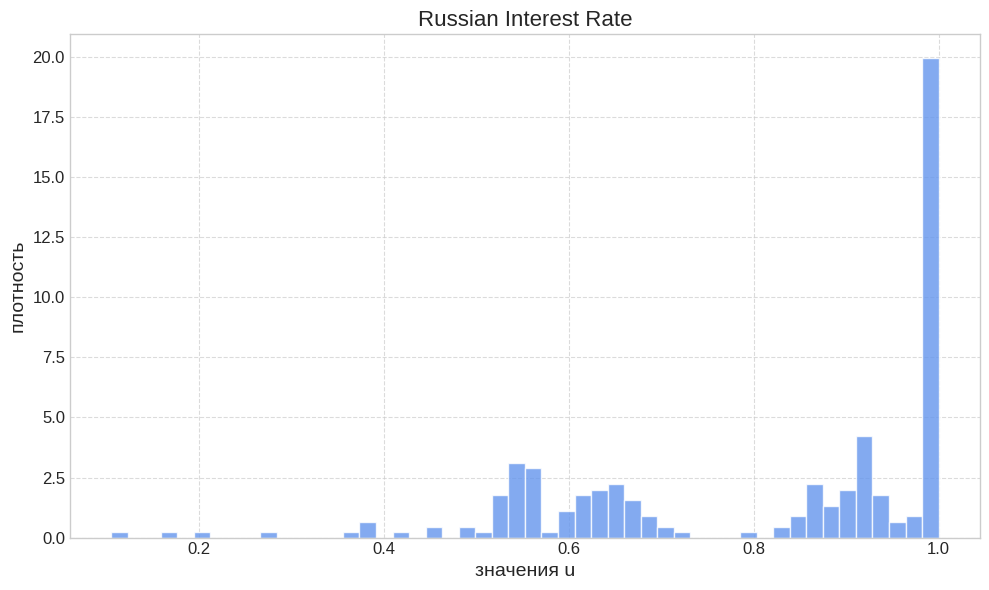


US Interest Rate:
KS статистика: 0.7356, P-value: 0.0000
Нулевую гипотеза о том, что реализации попрождают равномерное распределение отвергается
Модель плохо подходит под реальные данные


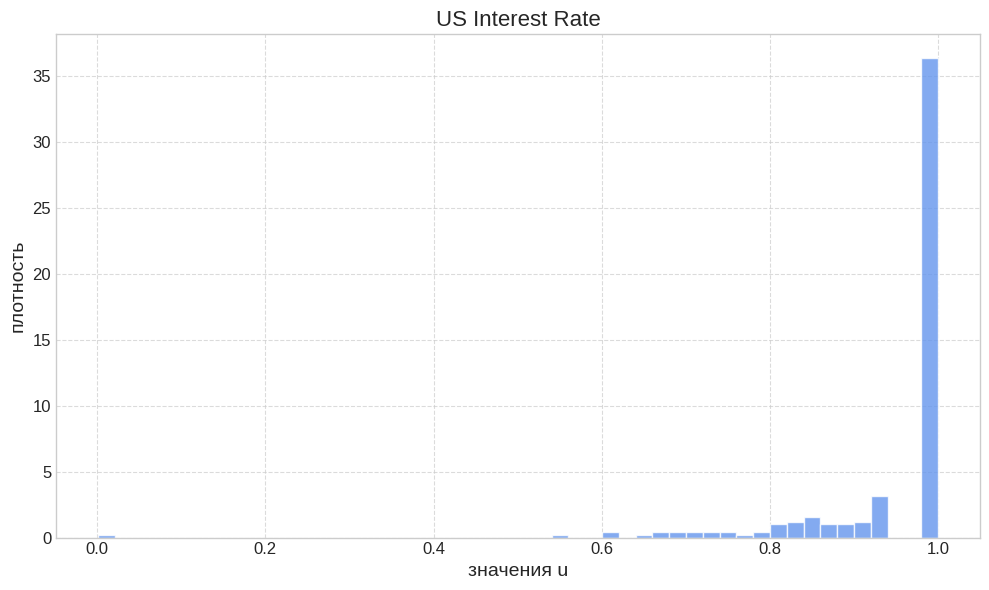


Exchange Rate:
KS статистика: 1.0000, P-value: 0.0000
Нулевую гипотеза о том, что реализации попрождают равномерное распределение отвергается
Модель плохо подходит под реальные данные


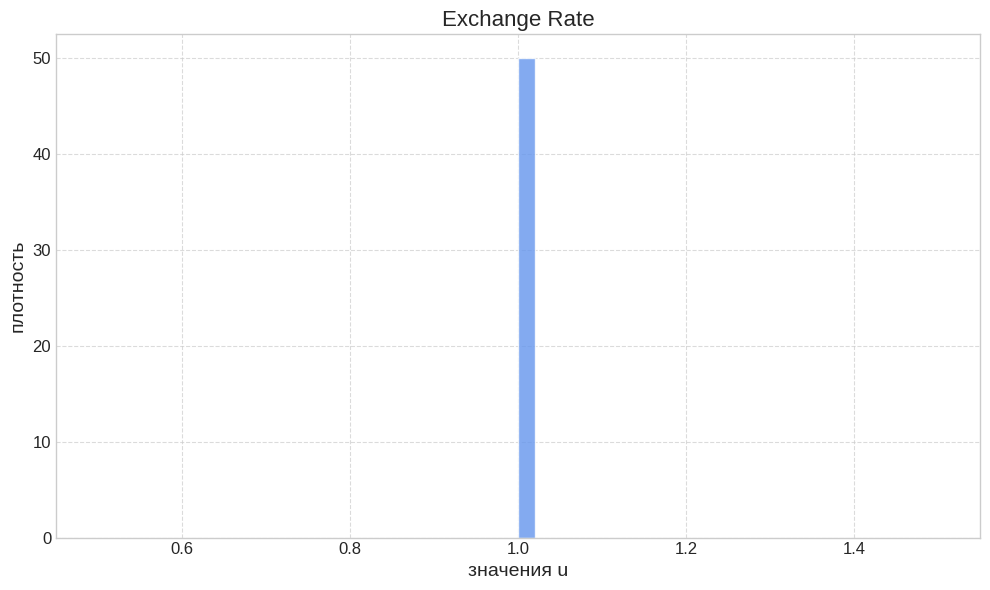

In [28]:
results_method_one = model_performance_one(simulated_data_dict, observed_data_dict)


Russian Interest Rate:
Число успехов: 124 из 252 попыток
P-value from binomial test: 0.0000
Отвергаем нулевую гипотезу:
Модель плохо подходит под реальные данные


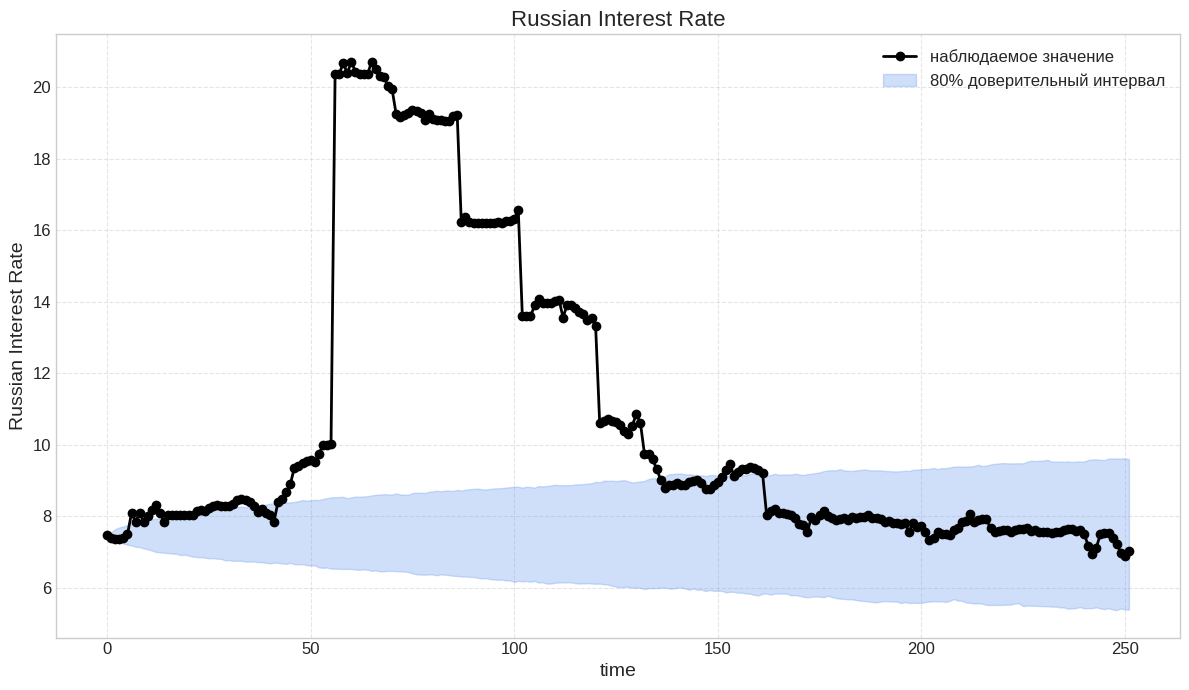


US Interest Rate:
Число успехов: 46 из 252 попыток
P-value from binomial test: 0.0000
Отвергаем нулевую гипотезу:
Модель плохо подходит под реальные данные


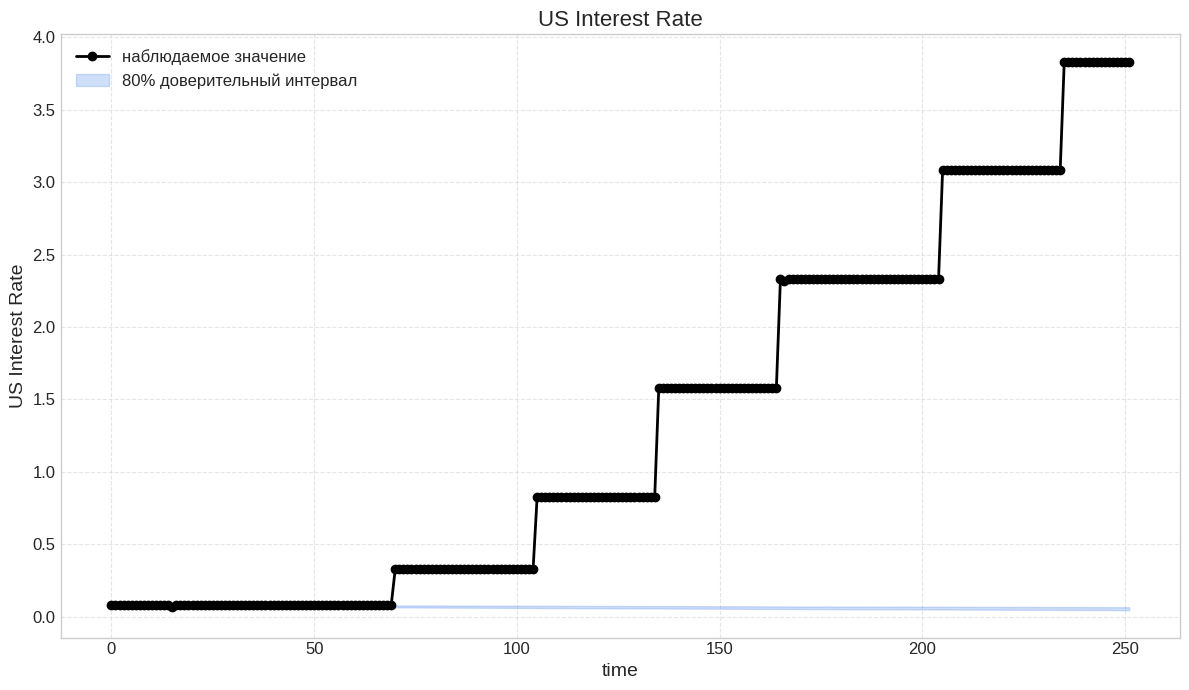


Exchange Rate:
Число успехов: 1 из 252 попыток
P-value from binomial test: 0.0000
Отвергаем нулевую гипотезу:
Модель плохо подходит под реальные данные


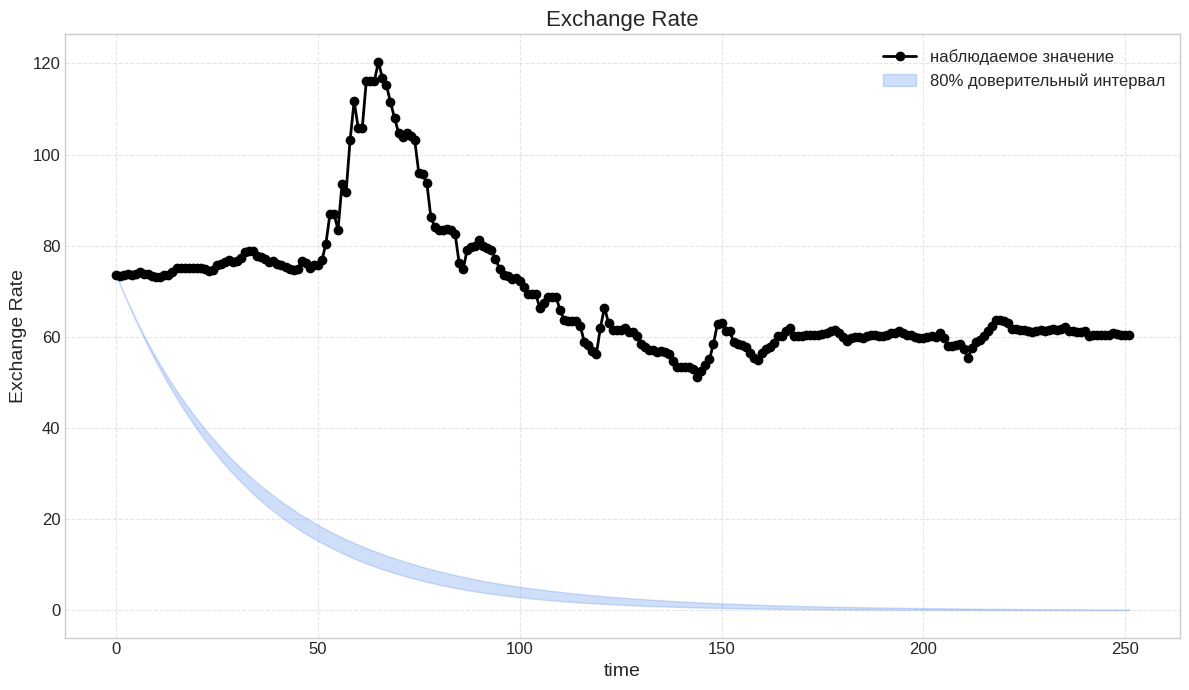

In [29]:
results_method_two = model_performance_two(simulated_data_dict, observed_data_dict)

В результате оценки качества прогнозов двумя методами для каждого фактора получилось, что модели демонстрируют слабую адаптацию к реальным данным. Основная причина заключается в использовании слишком длительного горизонта планирования — одного года. Сокращение этого интервала в симуляциях может значительно улучшить качество моделей.

### Range Accrual

In [30]:
# Симмуляция arnge accrual
def simulate_wo_plots(
    num_sims: int,
    N: int,
    T: int,
    data: np.array,
    k_ru: float,
    theta_ru: float,
    sigma_ru: float,
    lambda_j_ru: float,
    jump_mean_ru: float,
    jump_std_ru: float,
    k_us: float,
    theta_us: float,
    sigma_us: float,
    sigma_er: float
) -> Tuple[np.array]:

    r_ru_simulations = np.zeros((num_sims, N + 1))
    r_us_simulations = np.zeros((num_sims, N + 1))
    exch_rate_simulations = np.zeros((num_sims, N + 1))

    for sim_index in range(num_sims):
        wieners = generate_wieners_for_simulations(
            N=N,
            T=T,
            corrs=correlations(data[['rate_rub', 'rate_usd', 'exchange_rate']].values)
        )

        r_ru = simulate_cir_with_jumps(
            wiener=wieners[0, :],
            k=k_ru,
            theta=theta_ru,
            sigma=sigma_ru,
            r0=data['rate_rub'].iloc[-1],
            T=T,
            N=N,
            lambda_j=lambda_j_ru,
            jump_mean=jump_mean_ru,
            jump_std=jump_std_ru
        )

        r_us = simulate_cir(
            wiener=wieners[1, :],
            k=k_us,
            theta=theta_us,
            sigma=sigma_us,
            r0=data['rate_usd'].iloc[-1],
            T=T,
            N=N
        )

        exch_rate = simulate_exchange_rate(
            wiener=wieners[2, :],
            r_ru=r_ru,
            r_us=r_us,
            sigma=sigma_er,
            s0=data['exchange_rate'].iloc[-1],
            T=T,
            N=N
        )

        r_ru_simulations[sim_index, :] = r_ru
        r_us_simulations[sim_index, :] = r_us
        exch_rate_simulations[sim_index, :] = exch_rate

    return r_ru_simulations, r_us_simulations, exch_rate_simulations

In [31]:
class RangeAccrual:
    def __init__(self,
                 up_bound,
                 low_bound,
                 nominal,
                 date_start,
                 date_end,
                 data,
                 num_sims=1000,
                 days_backward=252,
                 T=1,
                 initial_params_ru=[0.5, 0.1, 0.05, 1, 0.05, 1],
                 bounds_ru=[(1e-4, None), (1e-6, None), (1e-4, None), (1e-6, None), (None, None), (1e-6, None)],
                 initial_params_us=[0.5, 0.02, 0.01],
                 bounds_us=[(1e-6, None), (1e-6, None), (1e-6, None)]
        ):
        self.up_bound = up_bound
        self.low_bound = low_bound
        self.nominal = nominal
        self.date_start = pd.to_datetime(date_start)
        self.date_end = pd.to_datetime(date_end)
        self.N = (self.date_end - self.date_start).days
        self.T = T
        self.dt = self.T / days_backward
        self.data = self.get_historical_data(data, days_backward)
        self.num_sims = num_sims
        self.days_backward = days_backward
        self.initial_params_ru=initial_params_ru
        self.bounds_ru=bounds_ru
        self.initial_params_us=initial_params_us
        self.bounds_us=bounds_us

    def get_historical_data(self, data, days):
        current_date = self.date_start
        date_start = current_date - pd.Timedelta(days=days)
        mask1 = data['dttm'] > date_start
        mask2 = data['dttm'] <= current_date
        return data[mask1 & mask2].sort_values(by='dttm')

    def choose_params(self):
        # Подбор параметров RU ставки
        k_ru, theta_ru, sigma_ru, lambda_j_ru, jump_mean_ru, jump_std_ru = cir_with_jumps_params(
                                    self.data['rate_rub'].values,
                                    self.initial_params_ru,
                                    self.T / self.days_backward,
                                    self.bounds_ru,
                                    log_likelihood_cir_jumps)

        # Подбор параметров US ставки
        k_us, theta_us, sigma_us = cir_params(self.data['rate_usd'].values,
                                    self.initial_params_us,
                                    self.T / self.days_backward,
                                    self.bounds_us,
                                    log_likelihood_cir)

        # Подбор параметров Exchange Rate
        sigma_er = np.std(np.diff(np.log(self.data['exchange_rate'])))

        return (k_ru, theta_ru, sigma_ru, lambda_j_ru, jump_mean_ru, jump_std_ru, k_us, theta_us, sigma_us, sigma_er)


    def make_simulations(self):
        (
            k_ru,
            theta_ru,
            sigma_ru,
            lambda_j_ru,
            jump_mean_ru,
            jump_std_ru,
            k_us,
            theta_us,
            sigma_us,
            sigma_er
        ) =  self.choose_params()
        r_ru_simulations, r_us_simulations, exch_rate_simulations = simulate_wo_plots(
            num_sims=self.num_sims,
            N=self.N,
            T=self.N/self.days_backward,
            data=self.data,
            k_ru=k_ru,
            theta_ru=theta_ru,
            sigma_ru=sigma_ru,
            lambda_j_ru=lambda_j_ru,
            jump_mean_ru=jump_mean_ru,
            jump_std_ru=jump_std_ru,
            k_us=k_us,
            theta_us=theta_us,
            sigma_us=sigma_us,
            sigma_er=sigma_er
        )
        return r_ru_simulations, r_us_simulations, exch_rate_simulations

    def results_plotting(self, fx):
        plt.figure(figsize=(10, 6))
        plt.plot(fx.T, alpha=0.7)
        plt.plot(fx.mean(axis=0), label='mean_value', color='k')
        plt.axhline(y=self.low_bound, color='red', linestyle='--', label=f'lower_bound = {self.low_bound}', linewidth=1.5)
        plt.axhline(y=self.up_bound, color='red', linestyle='--', label=f'upper_bound = {self.up_bound}', linewidth=1.5)
        plt.title('Exchange Rate')
        plt.xlabel('time')
        plt.ylabel('Exchange Rate')
        plt.legend()
        plt.show()

    def calc_results(self):
        r_for, r_dom, fx = self.make_simulations()
        payoff_flags = np.mean([((fx_t > self.low_bound) & (fx_t < self.up_bound)).astype(int) for fx_t in fx])
        RA = payoff_flags * self.nominal
        payoffs = payoff_flags
        self.results_plotting(fx)
        return (r_for, r_dom, fx), payoffs, RA


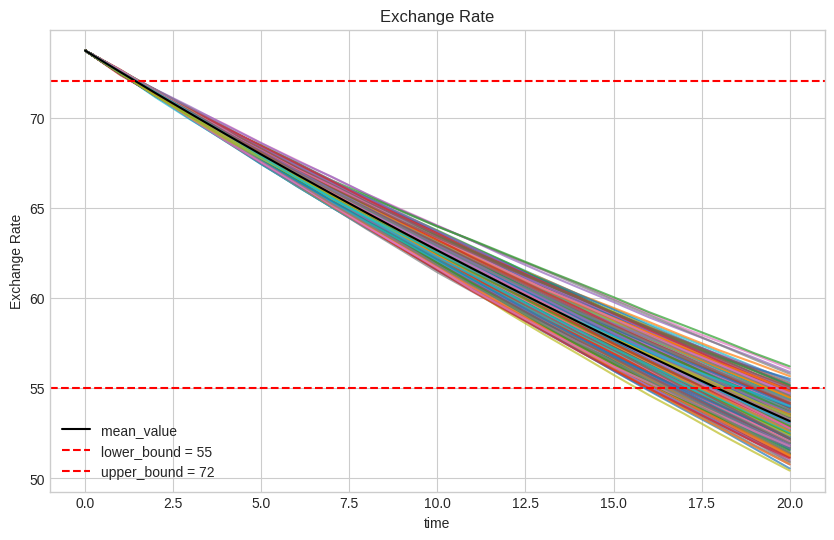

In [32]:
date_start = '2020-12-10'
date_end = '2020-12-30'
low_bound = 55
up_bound = 72
nominal = 1000

range_accrual = RangeAccrual(
    date_start=date_start,
    date_end=date_end,
    low_bound=low_bound,
    up_bound=up_bound,
    nominal=nominal,
    data=df_reduced
)

results, payoffs, RA = range_accrual.calc_results()

In [33]:
print(f'Справедливая цена: {RA:.2f}')

Справедливая цена: 784.52
